In [26]:
# Env: dqn_roost as of 15/1/2022 (after addition of ROOST)
import numpy as np
import pickle5 as pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch, DCN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env_constrained import generate_random_act, ConstrainedMaterialEnvironment, extract_data_from_ep, generate_random_ep, predict_sinter
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
from pymatgen.core import Composition
from constraints.checkers import check_neutrality, check_neutrality, check_neutrality_multiple, check_electronegativity_multiple, check_both_multiple
from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import joblib
from roost_models.roost_model import predict_formation_energy, predict_bulk_mod, predict_shear_mod, predict_band_gap
import json
from configs import configs
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"]="1"
print(torch.cuda.is_available())

True


In [27]:
# Load predicted formation energies of random oxides 
with open('./training_data/oxides_sinter_bulk_mod_1-62/sinter_random.pkl', 'rb') as f: 
    sinter_random = pickle.load(f)

# Load predicted bulk mod of random oxides 
with open('./training_data/oxides_sinter_bulk_mod_1-62/bulk_mod_random.pkl', 'rb') as f: 
    bulk_mod_random = pickle.load(f)

In [28]:
# Load predicted formation energies of constrained DQN
ratios = [
          '1-250',
          '1-125',
          '1-62'
          ]
sinter_dict   = {}
bulk_mod_dict = {}


for ratio in ratios:
    with open('./training_data/oxides_sinter_bulk_mod_{}/sinter_500iter_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        sinter_constrained = pickle.load(f)
        sinter_dict[ratio] = sinter_constrained

    # Load predicted bulk mod of constrained DQN
    with open('./training_data/oxides_sinter_bulk_mod_{}/bulk_mod_500iter_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        bulk_mod_constrained = pickle.load(f)
        bulk_mod_dict[ratio] = bulk_mod_constrained

In [29]:
# visualize compounds
# Load generated compounds of constrained DQN
compounds_dict   = {}

for ratio in ratios:
    with open('./training_data/oxides_sinter_bulk_mod_{}/final_compounds_roost_constrained.pkl'.format(ratio), 'rb') as f: 
        compounds = pickle.load(f)
        compounds_dict[ratio] = compounds

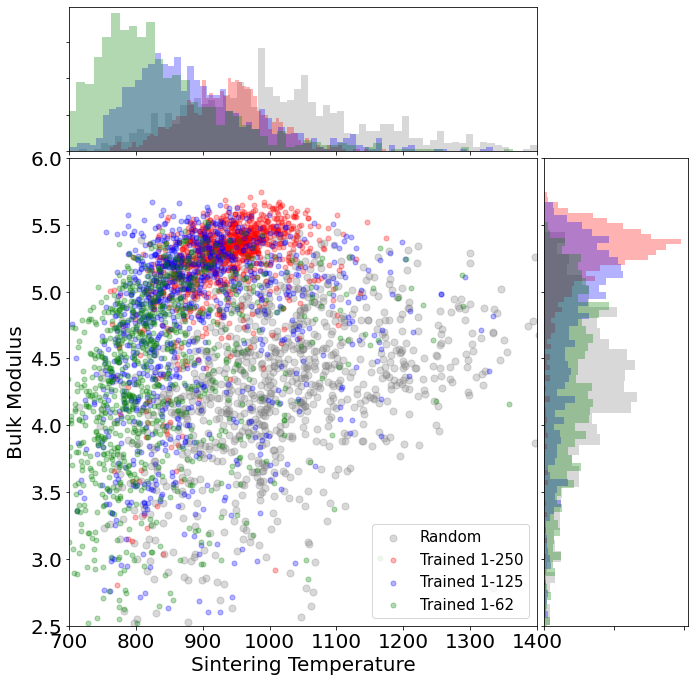

In [30]:
compounds_to_check = []
# 2D plot
# definitions for the axes
colors = ['red', 'blue', 'green']
alpha = 0.3
bins = 75

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels from histogram
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)

ax.scatter(sinter_random, bulk_mod_random, alpha = 0.3, color = 'grey', s = 50, label = 'Random')
ax_histx.hist(sinter_random, color = 'grey', alpha = 0.3, bins = bins)
ax_histy.hist(bulk_mod_random, color = 'grey', alpha = 0.3, bins = bins, orientation='horizontal')

count = 0
for ratio in ratios:
    ax.scatter(sinter_dict[ratio], bulk_mod_dict[ratio], color = colors[count], alpha = alpha, s = 25, label = 'Trained '+ratio)
    ax_histx.hist(sinter_dict[ratio], color = colors[count], alpha = 0.3, bins = bins)
    ax_histy.hist(bulk_mod_dict[ratio], color = colors[count], alpha = 0.3, bins = bins, orientation='horizontal')
    compounds = compounds_dict[ratio]
    
    count += 1

    # labels for compounds on pareto front
    pareto_threshold = 480
    x_weight, y_weight = ratio.split('-') # relative weights for two metrics
    x_weight, y_weight = float(x_weight), float(y_weight)
    for compound, x, y in zip(compounds, sinter_dict[ratio], bulk_mod_dict[ratio]):
        if -x_weight*x + y_weight*y > pareto_threshold: # plot if the combined metric is above a certain threshold
            compound = Composition(compound)
            compound = compound.reduced_formula 
            compounds_to_check.append(compound)
            # ax.text(x = x, y = y+0.2, s = compound, size = 7)

ax.set_xlabel('Sintering Temperature', size = 20)
ax.set_ylabel('Bulk Modulus', size = 20)
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize= 20)
ax.set_xlim(700, 1400)
plt.ylim(2.5,6)

ax.legend(fontsize = 15)
# plt.savefig(fname = 'plots/oxides_sinter_bulk_mod_2D_plot_diff_ratio_with_labels.png', dpi = 1000)
plt.show()

In [31]:
good, bad = check_both_multiple(compounds_to_check)
good, bad

(['Os5WO5',
  'Os7W2O5',
  'MoPt6O5',
  'Ir3RuO5',
  'Ir4PtRh2O5',
  'As3Os8PtAuO5',
  'P5Os2Pt5AuO5',
  'Ge5Mo2Ir9O5',
  'Ga2Os9Rh3O5',
  'Ga2Ge9Os5Rh3O5',
  'P5Ir8Os6O5',
  'Ga2Ir5Ru3O5',
  'Re5As7PO5',
  'Ge5Os9RhO5',
  'NiIr3Pt2O5',
  'Ga2Os4WO',
  'Re7GeAs5O',
  'Re7Ge3Ir8Pt3O5',
  'Ni2As7PPt6O'],
 ['Ge2Os9RuO5',
  'Ga2Ge3Ir12O5',
  'Ir7Os10(NO)5',
  'Pt4O5',
  'Re9Si5AuO5',
  'Ge5Ir5PdRu4O5',
  'GeOs4O',
  'SiGe3Ir5Ru8O5',
  'CrB2(Os2O)5',
  'GeIr12Os3O5',
  'P5Ir6Os8O5',
  'GaOs13RuO5',
  'GeIr8Os9O5'])